In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [2]:
# raw = np.genfromtxt("../mocksamples/noages.dat")
# raw = np.genfromtxt("../mocksamples/fiducial.dat")
# raw = np.genfromtxt("../mocksamples/small.dat")
raw = np.genfromtxt("../mocksamples/fiducial.dat")
data = vice.dataframe({})
data["[fe/h]"] = [row[0] for row in raw]
data["[o/fe]"] = [row[2] for row in raw]
# data["age"] = len(data["[fe/h]"]) * [float("nan")]
data["age"] = [10**row[4] for row in raw]
# data["logage"] = [row[4] for row in raw]

<ipython-input-10-de7b5df116a7>:24: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


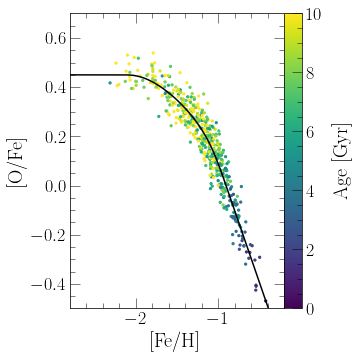

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel("[O/Fe]")
# ax.set_xlim([-1.7, 0.2])
# ax.set_ylim([-0.1, 0.5])
ax.set_xlim([-2.8, -0.2])
ax.set_ylim([-0.5, 0.7])
kwargs = {
    "s": 5,
#     "c": named_colors()["black"]
    "c": data["age"],
    "vmin": 0,
    "vmax": 10,
    "cmap": "viridis"
}
sc = ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
with vice.output("../mock") as out:
    ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["black"])
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 10)
cbar.set_ticks(range(0, 12, 2))
plt.tight_layout()
plt.subplots_adjust(right = 0.8)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
plt.savefig("../mocksamples/fiducial_ofe_feh.jpeg")
plt.show()

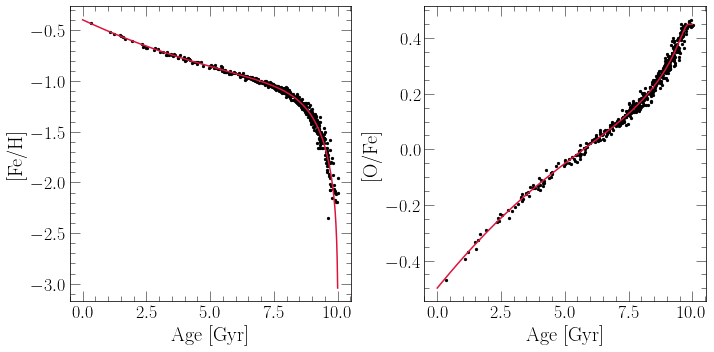

In [4]:
fig = plt.figure(figsize = (10, 5))
axes = []
ylabels = ["[Fe/H]", "[O/Fe]"]
for i in range(2):
    axes.append(fig.add_subplot(121 + i))
    axes[i].set_xlabel("Age [Gyr]")
    axes[i].set_ylabel(ylabels[i])
    
kwargs = {
    "s": 5,
    "c": named_colors()["black"]
}
for i in range(len(axes)):
    axes[i].scatter(data["age"], data[ylabels[i]], **kwargs)
    axes[i].plot(out.history["lookback"], out.history[ylabels[i]], c = named_colors()["crimson"])
plt.tight_layout()
plt.show()

In [3]:
# raw_chain = np.genfromtxt("../mockchain.out")
# raw_chain = np.genfromtxt("../mockchain_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/fiducial_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/precise_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/imprecise_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/large_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/small_5000.out")
# raw_chain = np.genfromtxt("../mocksamples/noages_5000.out")
raw_chain = np.genfromtxt("../mocksamples/lowered_yields_5000.out")
mcmc_chain = {}
mcmc_chain["tau_in"] = [row[0] for row in raw_chain]
mcmc_chain["tau_star"] = [row[1] for row in raw_chain]
mcmc_chain["eta"] = [row[2] for row in raw_chain]
mcmc_chain["logp"] = [row[3] for row in raw_chain]
true_values = {
    "tau_in": 2,
    "tau_star": 10,
    "eta": 25
}
max_idx = mcmc_chain["logp"].index(max(mcmc_chain["logp"]))

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
<ipython-input-4-18452e9aee31>:100: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


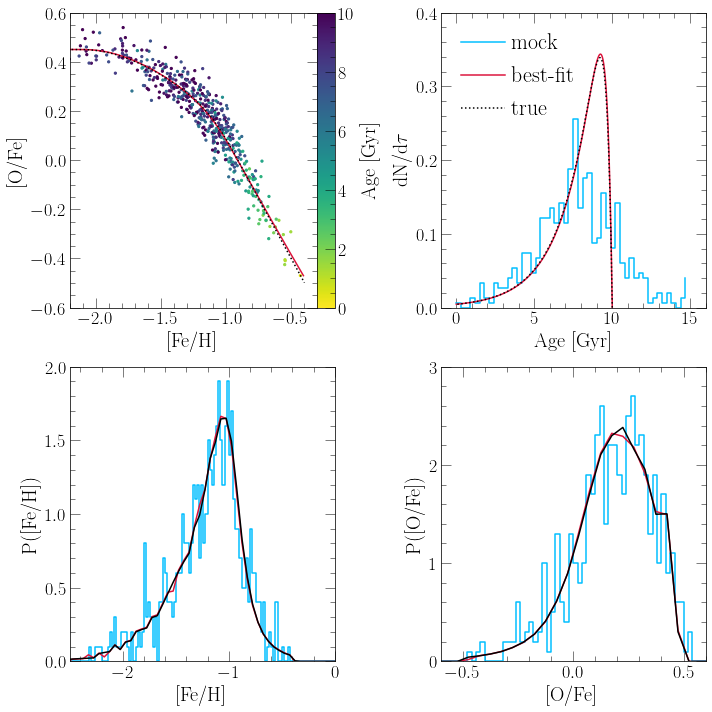

In [4]:
# vice.yields.ccsne.settings['o'] /= 3
# vice.yields.ccsne.settings['fe'] /= 3
# vice.yields.sneia.settings['fe'] /= 3

fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)
#         if i or j:
#             axes[i][j].set_yscale("log")
#             axes[i][j].yaxis.set_major_formatter(fsf("%g"))
        
axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel("[O/Fe]")
axes[0][0].set_xlim([-2.2, -0.3])
axes[0][0].set_ylim([-0.6, 0.6])

with vice.singlezone(name = "bestfit") as sz:
    sz.func = exponential(timescale = 1.97)
    sz.mode = "ifr"
    sz.elements = ["fe", "o"]
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 3.20
    sz.eta = 7.98
    bfout = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True)
    axes[0][0].plot(bfout.history["[fe/h]"], bfout.history["[o/fe]"],
        c = named_colors()["crimson"], label = "best-fit")

kwargs = {
    "s": 5,
#     "c": named_colors()["black"]
    "c": data["age"],
    "vmin": 0,
    "vmax": 10,
    "cmap": "viridis_r"
}
mockout = vice.output("../mock")
sc = axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
axes[0][0].plot(mockout.history["[fe/h]"], mockout.history["[o/fe]"],
    c = named_colors()["black"], linestyle = ':', label = "actual")
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 5)
cbar.set_ticks(range(0, 12, 2))

axes[0][1].set_xlabel(r"Age [Gyr]")
axes[0][1].set_ylabel(r"dN/d$\tau$")
axes[0][1].set_xlim([-1, 16])
# axes[0][1].set_xlim([-1, 11])
axes[0][1].set_ylim([0, 0.4])
axes[0][1].set_yticks([0, 0.1, 0.2, 0.3, 0.4])
hist, bins = np.histogram(data["age"], bins = 50, range = [0, 15], density = True)
axes[0][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
dt = bfout.history["time"][1] - bfout.history["time"][0]
norm = sum(bfout.history["sfr"]) * dt
agedist = [_ / norm for _ in bfout.history["sfr"]]
axes[0][1].plot(bfout.history["lookback"], agedist, c = named_colors()["crimson"], label = "best-fit")
norm = sum(mockout.history["sfr"]) * dt
agedist = [_ / norm for _ in mockout.history["sfr"]]
axes[0][1].plot(mockout.history["lookback"], agedist, c = named_colors()["black"], label = "true", linestyle = ':')

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "fontsize": 22
}
leg = axes[0][1].legend(**kwargs)

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.5, 0])
axes[1][0].set_ylim([0, 2])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5, 2.0])
hist, bins = np.histogram(data["[fe/h]"], bins = 200, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
xvals = [(a + b) / 2 for a, b in zip(bfout.mdf["bin_edge_left"], bfout.mdf["bin_edge_right"])]
yvals = bfout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[fe/h]"]
axes[1][0].plot(xvals, yvals, c = named_colors()["black"], label = "true")

axes[1][1].set_xlabel("[O/Fe]")
axes[1][1].set_ylabel("P([O/Fe])")
axes[1][1].set_xlim([-0.6, 0.6])
axes[1][1].set_ylim([0, 3])
axes[1][1].set_yticks([0, 1, 2, 3])
hist, bins = np.histogram(data["[o/fe]"], bins = 200, range = [-3, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["deepskyblue"], label = "mock")
yvals = bfout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = mockout.mdf["dn/d[o/fe]"]
axes[1][1].plot(xvals, yvals, c = named_colors()["black"], label = "true")

# kwargs = {
#     "loc": mpl_loc("upper left"),
#     "ncol": 1,
#     "fontsize": 22
# }
# leg = axes[1][1].legend(**kwargs)

plt.tight_layout()
plt.subplots_adjust(wspace = 0.4, hspace = 0.2)
axes[0][0].set_position([
    axes[0][0].get_position().x0,
    axes[0][0].get_position().y0,
    axes[0][0].get_position().x1 - axes[0][0].get_position().x0 - 0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
cbar_ax.set_position([
    axes[0][0].get_position().x1,
    axes[0][0].get_position().y0,
    0.025,
    axes[0][0].get_position().y1 - axes[0][0].get_position().y0
])
for ext in ["pdf", "jpeg"]: plt.savefig("./lowered_yields_distributions.%s" % (ext))
plt.show()

best-fit eta: 25.6659 +0.8641 -0.5159
best-fit tau_star: 11.5224 +0.6786 -1.0854


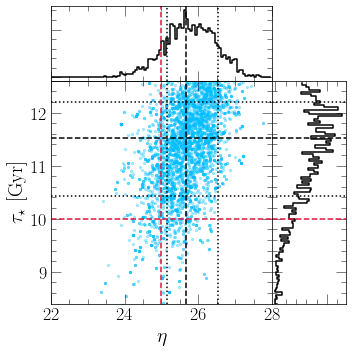

In [6]:
fig = plt.figure()
gs = GridSpec(4, 4, wspace = 0, hspace = 0)
ax = fig.add_subplot(gs[1:4,0:3])
top = fig.add_subplot(gs[0,0:3], sharex = ax)
right = fig.add_subplot(gs[1:4,3], sharey = ax)

save = False
figname = "taustar_eta_small"

xkey = "eta"
xlabel = r"$\eta$"
ykey = "tau_star"
ylabel = r"$\tau_\star$ [Gyr]"
# ykey = "tau_in"
# ylabel = r"$\tau_\text{in}$ [Gyr]"
limits = {
    "eta": [22, 28],
#     "eta": [24.1, 24.6],
    "tau_in": [1.7, 2.3],
#     "tau_in": [1.95, 2.05],
    "tau_star": [8.4, 12.6]
#     "tau_star": [9.5, 10.5]
}
xlim = limits[xkey]
ylim = limits[ykey]

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
ax.set_xlim(xlim)
ax.set_ylim(ylim)

for i in [top, right]:
    plt.setp(i.get_xticklabels(), visible = False)
    plt.setp(i.get_yticklabels(), visible = False)

scatter_kwargs = {
    "c": named_colors()["deepskyblue"],
    "s": 5,
    "alpha": 0.3
}
true_value_kwargs = {
    "c": named_colors()["crimson"],
    "linestyle": '--'
}

ax.scatter(mcmc_chain[xkey], mcmc_chain[ykey], **scatter_kwargs)

nbins = 100
xhist, xbins = np.histogram(mcmc_chain[xkey], bins = nbins, range = ax.get_xlim(), density = True)
yhist, ybins = np.histogram(mcmc_chain[ykey], bins = nbins, range = ax.get_ylim(), density = True)

sixteen = [0, 0]
s = [0, 0]
eightyfour = [0, 0]
e = [0, 0]
for i in range(nbins):
    if s[0] >= 0.16 and sixteen[0] == 0:
        sixteen[0] = (xbins[i + 1] + xbins[i]) / 2
    else:
        s[0] += xhist[i] * (xbins[i + 1] - xbins[i])
    if s[1] >= 0.16 and sixteen[1] == 0:
        sixteen[1] = (ybins[i + 1] + ybins[i]) / 2
    else:
        s[1] += yhist[i] * (ybins[i + 1] - ybins[i])
    if e[0] >= 0.84 and eightyfour[0] == 0:
        eightyfour[0] = (xbins[i + 1] + xbins[i]) / 2
    else:
        e[0] += xhist[i] * (xbins[i + 1] - xbins[i])
    if e[1] >= 0.84 and eightyfour[1] == 0:
        eightyfour[1] = (ybins[i + 1] + ybins[i]) / 2
    else:
        e[1] += yhist[i] * (ybins[i + 1] - ybins[i])

# print(sixteen)
# print([mcmc_chain[xkey][max_idx], mcmc_chain[ykey][max_idx]])
# print(eightyfour)
print("best-fit %s: %.4f +%.4f -%.4f" % (xkey,
    mcmc_chain[xkey][max_idx],
    eightyfour[0] - mcmc_chain[xkey][max_idx],
    mcmc_chain[xkey][max_idx] - sixteen[0]))
print("best-fit %s: %.4f +%.4f -%.4f" % (ykey,
    mcmc_chain[ykey][max_idx],
    eightyfour[1] - mcmc_chain[ykey][max_idx],
    mcmc_chain[ykey][max_idx] - sixteen[1]))

hist_kwargs = {
    "c": named_colors()["black"]
}

top.step(xbins[:-1], xhist, where = "post", **hist_kwargs)
right.step(yhist, ybins[:-1], where = "post", **hist_kwargs)

fit_kwargs = {
    "c": named_colors()["black"]
}

ax.plot(2 * [sixteen[0]], ax.get_ylim(), linestyle = ':', **fit_kwargs)
ax.plot(2 * [mcmc_chain[xkey][max_idx]], ax.get_ylim(), linestyle = '--', **fit_kwargs)
ax.plot(2 * [eightyfour[0]], ax.get_ylim(), linestyle = ':', **fit_kwargs)
ax.plot(ax.get_xlim(), 2 * [sixteen[1]], linestyle = ':', **fit_kwargs)
ax.plot(ax.get_xlim(), 2 * [mcmc_chain[ykey][max_idx]], linestyle = '--', **fit_kwargs)
ax.plot(ax.get_xlim(), 2 * [eightyfour[1]], linestyle = ':', **fit_kwargs)
ax.plot(2 * [true_values[xkey]], ax.get_ylim(), **true_value_kwargs)
ax.plot(ax.get_xlim(), 2 * [true_values[ykey]], **true_value_kwargs)

right_lim = right.get_xlim()
top_lim = top.get_ylim()

top.plot(2 * [sixteen[0]], top_lim, linestyle = ':', **fit_kwargs)
top.plot(2 * [mcmc_chain[xkey][max_idx]], top_lim, linestyle = '--', **fit_kwargs)
top.plot(2 * [eightyfour[0]], top_lim, linestyle = ':', **fit_kwargs)
top.plot(2 * [true_values[xkey]], top_lim, **true_value_kwargs)
top.set_ylim(top_lim)
right.plot(right_lim, 2 * [sixteen[1]], linestyle = ':', **fit_kwargs)
right.plot(right_lim, 2 * [mcmc_chain[ykey][max_idx]], linestyle = '--', **fit_kwargs)
right.plot(right_lim, 2 * [eightyfour[1]], linestyle = ':', **fit_kwargs)
right.plot(right_lim, 2 * [true_values[ykey]], **true_value_kwargs)
right.set_xlim(right_lim)

plt.tight_layout()
if save:
    for ext in ["pdf", "png"]: plt.savefig("./mock/%s.%s" % (figname, ext))
else: pass
plt.show()

The fiducial sample has N = 500 points with $\sigma(\text{[Fe/H]}) = \sigma(\text{[O/Fe]}) = 0.05$ and $\sigma(\text{age}) = 0.5$ Gyr with uncorrelated errors. The imprecise sample instead has $\sigma(\text{[Fe/H]}) = \sigma(\text{[O/Fe]}) = 0.2$ and $\sigma(\text{age}) = 1$ Gyr. The precise sample instead has $\sigma(\text{[Fe/H]}) = \sigma(\text{[O/Fe]}) = 0.01$ and $\sigma(\text{age}) = 0.1$ Gyr. The large sample instead has N = 2000 while the small sample instead has N = 500.

| Which Sample | $\eta$                  | $\tau_\star$ (Gyr)      | $\tau_\text{in}$ (Gyr)    |
|:-------------|:------------------------|:------------------------|:--------------------------|
| Imprecise    | $24.40^{+0.93}_{-0.63}$ | $9.79^{+1.03}_{-0.65}$  | $2.07^{+0.07}_{-0.10}$    |
| Precise      | $24.33^{+0.06}_{-0.04}$ | $9.87^{+0.11}_{-0.04}$  | $2.013^{+0.007}_{-0.005}$ |
| Fiducial     | $24.99^{+0.34}_{-0.26}$ | $9.86^{+0.41}_{-0.29}$  | $2.01^{+0.04}_{-0.03}$    |
| Large        | $24.41^{+0.26}_{-0.04}$ | $10.23^{+0.25}_{-0.17}$ | $2.01^{+0.02}_{-0.02}$    |
| Small        | $24.75^{+0.76}_{-0.56}$ | $11.07^{+0.67}_{-1.18}$ | $1.93^{+0.09}_{-0.05}$    |
| No Ages      | $24.75^{+0.40}_{-0.32}$ | $10.46^{+0.61}_{-0.65}$ | $1.97^{+0.10}_{-0.08}$    |

Uncertainty in $\eta$ is affected similarly by sample size and precision.
- A factor of 5 increase in precision tightened the likelihood distribution by a factor of $\sim$6
- A factor of 4 decrease in precision widened the likelihood distribution by a factor of $\sim$2.5
- A factor of 4 increase in sample size tightened the likelihood distribution by a factor of $\sim$2
- A factor of 5 decrease in sample size widened the likelihood distribution by a factor of $\sim$2

Uncertainty in $\tau_\star$ is affected similarly by sample size and precision, but there appears to be a threshold above which increases in precision have no impact on the uncertainty.
- A factor of 5 increase in precision tightened the likelihood distribution by a factor of $\sim$5
- A factor of 4 decrease in precision widened the likelihood distribution by a factor of $\sim$2
- A factor of 4 increase in sample size tightened the likelihood distribution by a factor of $\sim$2
- A factor of 5 decrease in sample size widened the likelihood distribution by a factor of $\sim$2.5

Uncertain in $\tau_\text{in}$ is affected similarly by sample size and precision.
- A factor of 5 increase in precision tightened the likelihood distribution by a factor of $\sim$7
- A factor of 4 decrease in precision widened the likelihood distribution by a factor of $\sim$2.5
- A factor of 4 increase in sample size tightened the likelihood distribution by a factor of $\sim$2.5
- A factor of 5 decrease in sample size widened the likelihood distribution by a factor of $\sim$2.

Neglecting age information in the fit:
- Marginally increased ($\sim$15%) the width of the likelihood distribution of $\eta$
- Widened the likelihood distribution of $\tau_\star$ by $\sim$80%
- Widened the likelihood distribution of $\tau_\text{in}$ by a factor of $\sim$2

... but nonetheless yielded fits consistent with the known values of these parameters, and **still** recovers the age distribution from the model which produced the mock sample almost exactly (see below).

| Chain Length | $\eta$                  | $\tau_\star$ (Gyr)      | $\tau_\text{in}$ (Gyr) |
|:-------------|:------------------------|:------------------------|:-----------------------|
| 1000         | $24.36^{+0.91}_{-0.29}$ | $10.00^{+0.75}_{-0.34}$ | $2.03^{+0.06}_{-0.08}$ |
| 2000         | $24.99^{+0.40}_{-0.56}$ | $9.85^{+0.58}_{-0.22}$  | $2.02^{+0.05}_{-0.05}$ |
| 3000         | $24.98^{+0.47}_{-0.19}$ | $9.84^{+0.50}_{-0.24}$  | $2.02^{+0.02}_{-0.06}$ |
| 4000         | $24.98^{+0.47}_{-0.19}$ | $9.86^{+0.47}_{-0.30}$  | $2.02^{+0.04}_{-0.04}$ |
| 5000         | $24.99^{+0.34}_{-0.26}$ | $9.86^{+0.41}_{-0.29}$  | $2.01^{+0.04}_{-0.03}$ |

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\
<ipython-input-8-b01b682ca867>:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


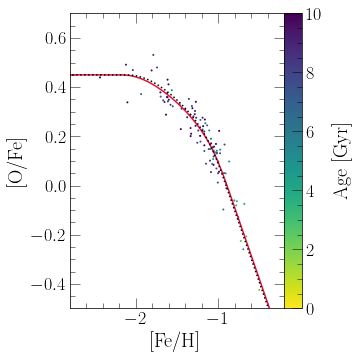

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("[Fe/H]")
ax.set_ylabel("[O/Fe]")
# ax.set_xlim([-1.7, 0.2])
# ax.set_ylim([-0.1, 0.5])
ax.set_xlim([-2.8, -0.2])
ax.set_ylim([-0.5, 0.7])

with vice.singlezone(name = "bestfit") as sz:
    sz.func = exponential(timescale = 2.02)
    sz.mode = "ifr"
    sz.elements = ["fe", "o"]
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 9.95
    sz.eta = 25.02
    out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True)
    ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["crimson"])

kwargs = {
    "s": 1,
#     "c": named_colors()["black"]
    "c": data["age"],
    "vmin": 0,
    "vmax": 10,
    "cmap": "viridis_r"
}
out = vice.output("../mock")
sc = ax.scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)
ax.plot(out.history["[fe/h]"], out.history["[o/fe]"], c = named_colors()["black"], linestyle = ':')
cbar_ax = fig.add_axes([0.92, 0.05, 0.02, 0.95])
cbar = plt.colorbar(sc, cax = cbar_ax, pad = 0.0, orientation = "vertical")
cbar.set_label("Age [Gyr]", labelpad = 10)
cbar.set_ticks(range(0, 12, 2))
plt.tight_layout()
plt.subplots_adjust(right = 0.8)
cbar_ax.set_position([
    ax.get_position().x1,
    ax.get_position().y0,
    0.05,
    ax.get_position().y1 - ax.get_position().y0
])
# for ext in ["pdf", "png"]: plt.savefig("./mock/ofe_feh_longchain.%s" % (ext))
plt.show()

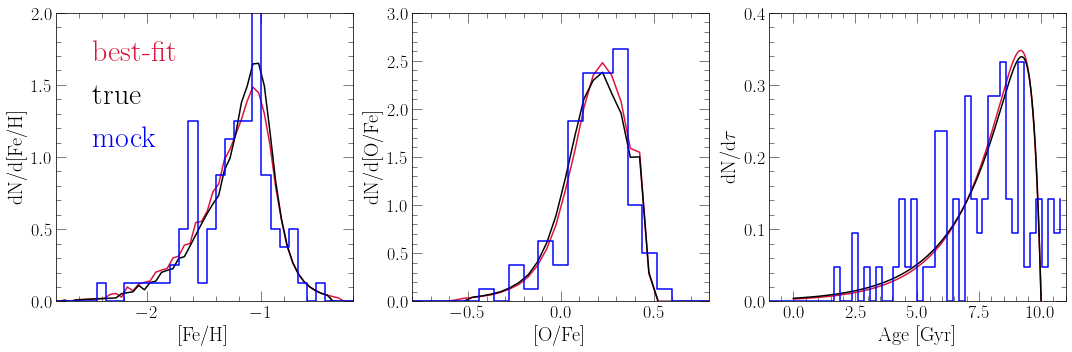

In [9]:
fig = plt.figure(figsize = (15, 5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
axes[0].set_xlabel("[Fe/H]")
axes[0].set_ylabel("dN/d[Fe/H]")
axes[1].set_xlabel("[O/Fe]")
axes[1].set_ylabel("dN/d[O/Fe]")
axes[2].set_xlabel("Age [Gyr]")
axes[2].set_ylabel(r"dN/d$\tau$")
axes[0].set_xlim([-2.8, -0.2])
axes[0].set_ylim([0, 2])
axes[0].set_yticks([0, 0.5, 1, 1.5, 2])
axes[1].set_xlim([-0.8, 0.8])
axes[1].set_ylim([0, 3])
axes[2].set_xlim([-1, 11])
axes[2].set_ylim([0, 0.4])
axes[2].set_yticks([0, 0.1, 0.2, 0.3, 0.4])

bf = vice.output("bestfit")
xvals = [(a + b) / 2 for a,b in zip(bf.mdf["bin_edge_left"], bf.mdf["bin_edge_right"])]
yvals = bf.mdf["dn/d[fe/h]"]
axes[0].plot(xvals, yvals, c = named_colors()["crimson"], label = "best-fit")
yvals = bf.mdf["dn/d[o/fe]"]
axes[1].plot(xvals, yvals, c = named_colors()["crimson"])
norm = 0
xvals = bf.history["time"]
dt = xvals[1] - xvals[0]
for i in range(len(bf.history["time"])):
    norm += bf.history["sfr"][i] * dt
yvals = [_ / norm for _ in bf.history["sfr"][::-1]]
axes[2].plot(xvals, yvals, c = named_colors()["crimson"])

true = vice.output("../mock")
xvals = [(a + b) / 2 for a,b in zip(true.mdf["bin_edge_left"], true.mdf["bin_edge_right"])]
yvals = true.mdf["dn/d[fe/h]"]
axes[0].plot(xvals, yvals, c = named_colors()["black"], label = "true")
yvals = true.mdf["dn/d[o/fe]"]
axes[1].plot(xvals, yvals, c = named_colors()["black"])
norm = 0
xvals = true.history["time"]
dt = xvals[1] - xvals[0]
for i in range(len(true.history["time"])):
    norm += true.history["sfr"][i] * dt
yvals = [_ / norm for _ in true.history["sfr"][::-1]]
axes[2].plot(xvals, yvals, c = named_colors()["black"])

mock_hist, mock_bins = np.histogram(data["[fe/h]"], bins = 50, range = [-3, 1], density = True)
axes[0].step(mock_bins[:-1], mock_hist, where = "post", c = named_colors()["blue"], label = "mock")
mock_hist, mock_bins = np.histogram(data["[o/fe]"], bins = 50, range = [-3, 1], density = True)
axes[1].step(mock_bins[:-1], mock_hist, where = "post", c = named_colors()["blue"])
mock_hist, mock_bins = np.histogram(data["age"], bins = 50, range = [-1, 11], density = True)
axes[2].step(mock_bins[:-1], mock_hist, where = "post", c = named_colors()["blue"])

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 30
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, ["crimson", "black", "blue"])

plt.tight_layout()
# for ext in ["pdf", "png"]: plt.savefig("./mock/distributions_longchain.%s" % (ext))
plt.show()

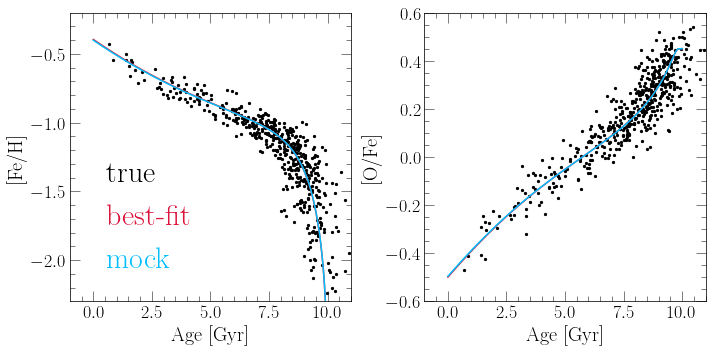

In [13]:
fig = plt.figure(figsize = (10, 5))
axes = []
for i in range(2):
    axes.append(fig.add_subplot(121 + i))
    axes[i].set_xlabel("Age [Gyr]")
    axes[i].set_ylabel(["[Fe/H]", "[O/Fe]"][i])
    axes[i].set_xlim([-1, 11])
axes[0].set_ylim([-2.3, -0.2])
axes[1].set_ylim([-0.6, 0.6])

kwargs = {
    "c": named_colors()["black"],
    "label": "mock"
}
axes[0].scatter(data["age"], data["[fe/h]"], s = 5, **kwargs)
axes[1].scatter(data["age"], data["[o/fe]"], s = 5, **kwargs)

true = vice.output("../mock")
kwargs["c"] = named_colors()["crimson"]
kwargs["label"] = "true"
axes[0].plot(true.history["lookback"], true.history["[fe/h]"], **kwargs)
axes[1].plot(true.history["lookback"], true.history["[o/fe]"], **kwargs)

bf = vice.output("bestfit")
kwargs["c"] = named_colors()["deepskyblue"]
kwargs["label"] = "best-fit"
axes[0].plot(bf.history["lookback"], bf.history["[fe/h]"], **kwargs)
axes[1].plot(bf.history["lookback"], bf.history["[o/fe]"], **kwargs)

kwargs = {
    "loc": mpl_loc("lower left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 30
}
leg = axes[0].legend(**kwargs)
fancy_legend(leg, ["black", "crimson", "deepskyblue"])
plt.tight_layout()
plt.show()

In [2]:
from mockfit import expifr_mcmc
raw = np.genfromtxt("../mock.dat")
data = {
    "[fe/h]": np.array([row[0] for row in raw]),
    "[fe/h]_err": np.array([row[1] for row in raw]),
    "[o/fe]": np.array([row[2] for row in raw]),
    "[o/fe]_err": np.array([row[3] for row in raw]),
    "lookback": np.array([row[4] for row in raw]),
    "lookback_err": np.array([row[5] for row in raw])
}
test = expifr_mcmc(data)

In [5]:
test([2, 10, 25])

walker: [2.00000e+00, 1.00000e+01, 2.50000e+01] Success!


-1821.3729925320201

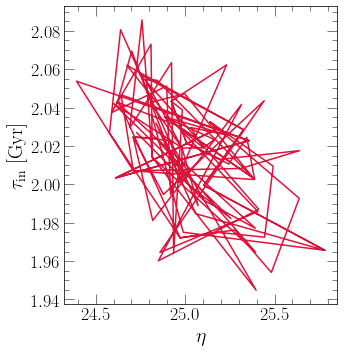

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.set_xlabel(r"$\tau_\star$ [Gyr]")
ax.set_xlabel(r"$\eta$")
ax.set_ylabel(r"$\tau_\text{in}$ [Gyr]")

n_walkers = 50
n_iters = len(mcmc_chain["tau_star"]) // n_walkers

walker = 1
xvals = mcmc_chain["eta"][(n_iters * walker):(n_iters * (walker + 1) + 1)]
yvals = mcmc_chain["tau_in"][(n_iters * walker):(n_iters * (walker + 1) + 1)]
ax.plot(xvals, yvals, c = named_colors()["crimson"])

plt.tight_layout()
plt.show()